<a href="https://colab.research.google.com/github/Ananassio/Data-Minig-Lab/blob/main/Projekt/Projekt_Data_Minig_22_23_Marius_Zimmermann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [160]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [161]:
#from google.colab import drive
#drive.mount('/content/drive')

# Daten import


In [162]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [163]:
GCS_PATH = 'drive/MyDrive/DataMinig/'

In [164]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [165]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [166]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [167]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [168]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

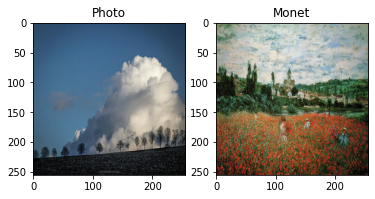

In [169]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Modelgenerierung

##Generator

In [170]:
def Generator():

  inputs = layers.Input(shape=[256,256,3])

    # Center-crop images to 150x150
  l1 = CenterCrop(height=150, width=150)(inputs)
    # Rescale images to [0, 1]
  l2 = Rescaling(scale=1.0 / 255)(l1)

    # Apply some convolution and pooling layers
  l3 = layers.Conv2D(filters=64, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l2)
  l4 = layers.MaxPooling2D(pool_size=(3, 3))(l3)
  l5 = layers.BatchNormalization()(l4)
  l6 = layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l5)
  l7 = layers.Dropout(0.4)(l6)
  l8 = layers.MaxPooling2D(pool_size=(3, 3))(l7)
  l9 = layers.Conv2D(filters=256, kernel_size=(3, 3), kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l8)
  l10 = layers.Dropout(0.4)(l9)
  l11 = layers.MaxPooling2D(pool_size=(3, 3))(l10)
  l12 = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu")(l11)
  l13 = layers.Dropout(0.4)(l12)

  l14 = layers.Conv2DTranspose(filters=512, kernel_size=(3, 3),strides=2,kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l13)
  l15 = layers.Dropout(0.4)(l14)
  l16 = layers.Conv2DTranspose(filters=256, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l15)
  l17 = layers.Dropout(0.4)(l16)
  l18 = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3),strides=4,kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l17)
  l19 = layers.BatchNormalization()(l18)
  l20 = layers.Conv2DTranspose(filters=75, kernel_size=(3, 3),strides=3,kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l19)
  l21 = layers.Dropout(0.4)(l20)
  l22 = layers.Conv2DTranspose(filters=20, kernel_size=(3, 3),strides=3,kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l21)
  l23 = layers.Dropout(0.4)(l22)
  l24 = layers.Conv2DTranspose(filters=3, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l23)

  outputs = layers.Conv2DTranspose(filters=3, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l24)

  return keras.Model(inputs=inputs, outputs=outputs)

In [171]:
inputs = layers.Input(shape=[256,256,3])

  # Center-crop images to 150x150
l1 = CenterCrop(height=150, width=150)(inputs)
  # Rescale images to [0, 1]
l2 = Rescaling(scale=1.0 / 255)(l1)

  # Apply some convolution and pooling layers
l3 = layers.Conv2D(filters=64, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l2)
l4 = layers.MaxPooling2D(pool_size=(3, 3))(l3)
l5 = layers.BatchNormalization()(l4)
l6 = layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l5)
l7 = layers.Dropout(0.4)(l6)
l8 = layers.MaxPooling2D(pool_size=(3, 3))(l7)
l9 = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu")(l8)
l10 = layers.Dropout(0.4)(l9)
l11 = layers.MaxPooling2D(pool_size=(3, 3))(l10)
l12 = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu")(l11)
l13 = layers.Dropout(0.4)(l12)

l14 = layers.Conv2DTranspose(filters=512, kernel_size=(3, 3),strides=2,kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l13)
l15 = layers.Dropout(0.4)(l14)
l16 = layers.Conv2DTranspose(filters=256, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l15)
l17 = layers.Dropout(0.4)(l16)
l18 = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3),strides=4,kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l17)
l19 = layers.BatchNormalization()(l18)
l20 = layers.Conv2DTranspose(filters=75, kernel_size=(3, 3),strides=3,kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l19)
l21 = layers.Dropout(0.4)(l20)
l22 = layers.Conv2DTranspose(filters=20, kernel_size=(3, 3),strides=3,kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l21)
l23 = layers.Dropout(0.4)(l22)
l24 = layers.Conv2DTranspose(filters=3, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l23)

outputs = layers.Conv2DTranspose(filters=3, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l24)

In [172]:


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 center_crop_30 (CenterCrop)  (None, 150, 150, 3)      0         
                                                                 
 rescaling_30 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 conv2d_201 (Conv2D)         (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 49, 49, 64)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_78 (Bat  (None, 49, 49, 64)       256       
 chNormalization)                                         

## Discriminator

In [173]:
def Discriminator():

  inputs = layers.Input(shape=[256,256,3])

  # Apply some convolution and pooling layers
  l1 = layers.Conv2D(filters=512, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(inputs)
  l2 = layers.GaussianNoise(0.8)(l1)
  l3 = layers.MaxPooling2D(pool_size=(3, 3))(l2)
  l4 = layers.BatchNormalization()(l3)
  l5 = layers.Conv2D(filters=256, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02), activation="relu")(l4)
  l6 = layers.GaussianDropout(0.4)(l5)
  l7 = layers.Conv2D(filters=128, kernel_size=(3, 3),strides=4, activation="relu")(l6)
  l8 = layers.MaxPooling2D(pool_size=(3, 3))(l7)
  l9 = layers.ZeroPadding2D()(l8)

  outputs = layers.Conv2D(filters=1, kernel_size=(3, 3), activation="relu")(l9)

  return keras.Model(inputs=inputs, outputs=outputs)

In [174]:

inputs = layers.Input(shape=[256,256,3])

  # Apply some convolution and pooling layers
l1 = layers.Conv2D(filters=512, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(inputs)
l2 = layers.GaussianNoise(0.8)(l1)
l3 = layers.MaxPooling2D(pool_size=(3, 3))(l2)
l4 = layers.BatchNormalization()(l3)
l5 = layers.Conv2D(filters=256, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02), activation="relu")(l4)
l6 = layers.GaussianDropout(0.4)(l5)
l7 = layers.Conv2D(filters=128, kernel_size=(3, 3),strides=4, activation="relu")(l6)
l8 = layers.MaxPooling2D(pool_size=(3, 3))(l7)
l9 = layers.ZeroPadding2D()(l8)

outputs = layers.Conv2D(filters=1, kernel_size=(3, 3), activation="relu")(l9)



In [175]:
model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_205 (Conv2D)         (None, 254, 254, 512)     14336     
                                                                 
 gaussian_noise_20 (Gaussian  (None, 254, 254, 512)    0         
 Noise)                                                          
                                                                 
 max_pooling2d_129 (MaxPooli  (None, 84, 84, 512)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_80 (Bat  (None, 84, 84, 512)      2048      
 chNormalization)                                                
                                                          

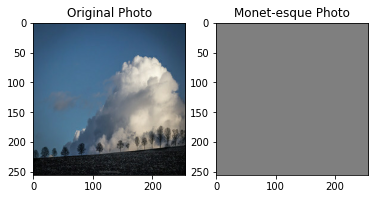

In [176]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## Build the CycleGAN model

In [177]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [178]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## define loss functions

In [179]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [180]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [181]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [182]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## train the cycle gan

In [183]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [184]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [185]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=1
)

300/300 [==============================] - 3065s 10s/step - monet_gen_loss: 11.6208 - photo_gen_loss: 12.1504 - monet_disc_loss: 0.6932 - photo_disc_loss: 0.6986


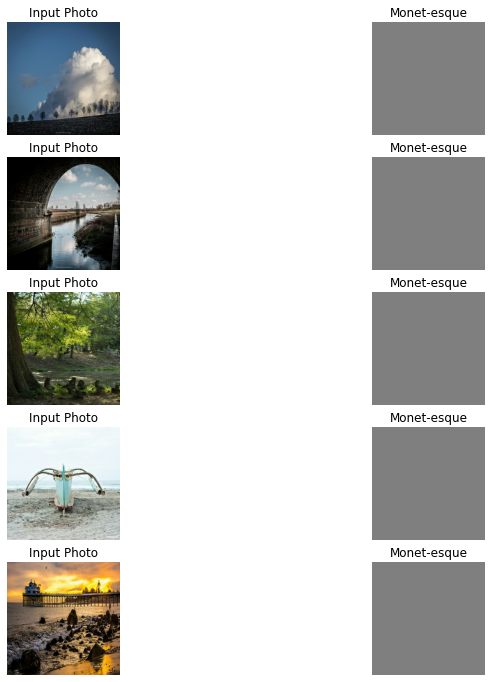

In [187]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()